In [260]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\Coditas\Desktop\Projects\Cauti\silver\silver_dataset.csv")
leakage_columns = [

    # ----- Direct infection evidence -----
    "urinalysis_wbc",
    "urinalysis_rbc",
    "urine_culture_performed",
    "cfu_count_measured",
    "gram_negative_organisms_present",
    "gram_positive_organisms_present",
    "fungi_present",
    "blood_culture_performed",
    "nitrite_tested",
    "nitrite_positive",

    # ----- Lab & biomarker responses -----
    "blood_wbc",
    "creatinine",
    "procalcitonin_measured",
    "blood_crp_measured",

    # ----- Vital signs reflecting infection -----
    "temperature",
    "heart_rate",
    "resp_rate",

    # ----- Clinical response to infection -----
    "antibiotics_per_admission",
    "recent_antibiotic_use",

    # ----- Explicit UTI / CAUTI knowledge -----
    "other_uti_present",
    "other_uti_uti_unspecified",
    "other_uti_cystitis",
    "other_uti_pyelonephritis",
    "other_uti_urethritis",
    "recurrent_uti",

    # ----- Outcome proxy -----
    "has_cauti_history",

    # ----- Renal output (often reactionary) -----
    "oliguria",
]
X = df.drop(columns=["y"] + leakage_columns)
y = df["y"].astype(int)

In [261]:
df.head()

,subject_id,hadm_id,gender,anchor_age,catheter_present,bmi,diabetes,cancer,chronic_kidney_disease,neurogenic_bladder,...,catheter_type_foley,catheter_type_nephrostomy,catheter_type_straight,catheter_type_suprapubic,catheter_type_unknown,catheter_type_ureteral,other_uti_uti_unspecified,other_uti_cystitis,other_uti_pyelonephritis,other_uti_urethritis
0,10000032,22595853,0,-0.643593,1,-1.539170,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,10000032,29079034,0,-0.643593,1,-1.508026,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,10000032,25742920,0,-0.643593,1,-1.508026,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10000560,28979390,0,-0.585292,1,0.064736,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,10000690,25860671,0,1.338645,1,-0.760575,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [262]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [263]:
# Fill remaining NaNs with 0 (safe because flags exist)
X_train = X_train.fillna(0)
X_val   = X_val.fillna(0)

In [264]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

In [265]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["AUC", "accuracy"]
)

C:\Users\Coditas\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [266]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


In [267]:
early_stop = EarlyStopping(
    monitor="val_auc",
    patience=5,
    mode="max",
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7916 - accuracy: 0.6797 - loss: 0.5483 - val_AUC: 0.8288 - val_accuracy: 0.7131 - val_loss: 0.4858
Epoch 2/50
 53/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8290 - accuracy: 0.7079 - loss: 0.4903

C:\Users\Coditas\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8269 - accuracy: 0.6998 - loss: 0.5022 - val_AUC: 0.8359 - val_accuracy: 0.6979 - val_loss: 0.5052
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8349 - accuracy: 0.7047 - loss: 0.4909 - val_AUC: 0.8397 - val_accuracy: 0.7215 - val_loss: 0.4654
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8395 - accuracy: 0.7097 - loss: 0.4842 - val_AUC: 0.8419 - val_accuracy: 0.7020 - val_loss: 0.4873
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8427 - accuracy: 0.7122 - loss: 0.4799 - val_AUC: 0.8428 - val_accuracy: 0.7241 - val_loss: 0.4705
Epoch 6/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8447 - accuracy: 0.7171 - loss: 0.4771 - val_AUC: 0.8434 - val_accuracy: 0.7147 - val_loss: 0.4844
Epoch 7/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8465 - accuracy: 0.7182 - loss: 0.4744 - val_AUC: 0.8433 - val_accuracy: 0.7222 - val_loss: 0.4729
Epoch 8/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

In [270]:
from sklearn.metrics import classification_report, roc_auc_score

# Predicted probabilities
y_val_prob = model.predict(X_val_scaled).ravel()

988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [273]:
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)

target_recall = 0.80
idx = np.where(recall >= target_recall)[0][-1]

best_threshold = thresholds[idx]
print("Best threshold (recall-based):", best_threshold)

# Apply best threshold
y_val_pred_best = (y_val_prob >= best_threshold).astype(int)

print(classification_report(y_val, y_val_pred_best))

Best threshold (recall-based): 0.50708586
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     27336
           1       0.30      0.80      0.44      4268

    accuracy                           0.73     31604
   macro avg       0.63      0.76      0.63     31604
weighted avg       0.87      0.73      0.77     31604



In [276]:
from sklearn.metrics import roc_auc_score
print("ROC AUC:", roc_auc_score(y_val, y_val_prob))

ROC AUC: 0.8403131538953339


# ROC curve

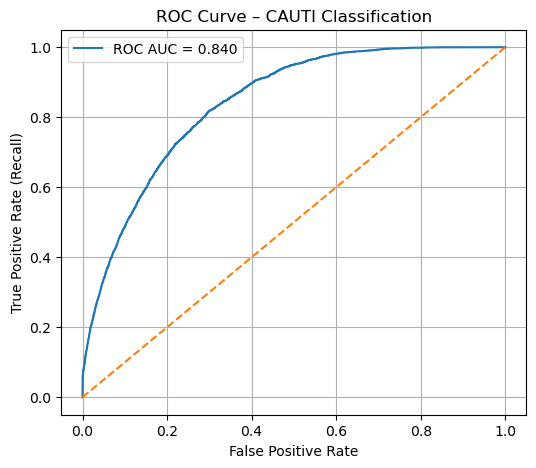

In [279]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_val, y_val_prob)
auc = roc_auc_score(y_val, y_val_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – CAUTI Classification")
plt.legend()
plt.grid(True)
plt.show()


# Precision Recall Curve

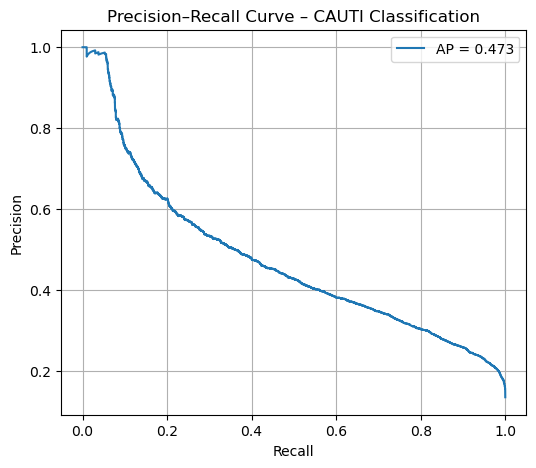

In [281]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_val, y_val_prob)
ap = average_precision_score(y_val, y_val_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – CAUTI Classification")
plt.legend()
plt.grid(True)
plt.show()


In [282]:
corr = X.corrwith(y).abs().sort_values(ascending=False)

high_corr = corr[corr >= 0.3]

print(high_corr)


Series([], dtype: float64)
